# Project 1
#### Norman Hong, Ryan Callahan, Nora Wu and Masha Gubenko
***

## Task 1 Exploratory Data analysis

The blocks below summarize statistical characteristics of the dev and gold datasets. 

In [ ]:
# Import Libraries
import re 
from statistics import stdev
import pandas as pd 
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment import SentimentAnalyzer
from math import log
import matplotlib
from matplotlib import pyplot as plt

import nltk 
from nltk import pos_tag
from nltk.corpus import stopwords 
from nltk.util import ngrams

# Read in the data
data = pd.read_csv("Dev/INPUT.txt", sep='\t', header=None, 
                   names=['id', 'target', 'tweet'], encoding='utf-8')
data.drop(['id', 'target'], axis=1, inplace=True)

# Tokenize
regexes=(
# Keep usernames together (any token starting with @, followed by A-Z, a-z, 0-9)        
r"(?:@[\w_]+)",
            
# Keep hashtags together (any token starting with #, followed by A-Z, a-z, 0-9, _, or -)
r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)",

# abbreviations, e.g. U.S.A.
r'(?:[A-Z]\.)+',
r'[A-Za-z]\.(?:[A-Za-z0-9]\.)+',
r'[A-Z][bcdfghj-np-tvxz]+\.',

# URL, e.g. https://google.com
r'https?:\/\/(?:www\.',
r'(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}',
r'www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}',
r'https?:\/\/(?:www\.',
r'(?!www))[a-zA-Z0-9]+\.[^\s]{2,}',
r'www\.[a-zA-Z0-9]+\.[^\s]{2,}',

# Currency and percentages, e.g. $12.40, 82%
r'\$?\d+(?:\.\d+)?%?',

# Numbers i.e. 123,56.34
r'(?:[0-9]+[,]?)+(?:[.][0-9]+)?',

# Keep words with apostrophes, hyphens, and underscores together
r"(?:[a-z][a-z’'\-_]+[a-z])",

# Keep all other sequences of A-Z, a-z, 0-9, _ together
r"(?:[\w_]+)",

# Match words at the end of a sentence.  e.g. tree. or tree!
r'(?:[a-z]+(?=[.!\?]))',

# Everything else that's not whitespace
# It seems like this captures punctuations and emojis and emoticons.  
#r"(?:\S)"
)

big_regex="|".join(regexes)
my_extensible_tokenizer = re.compile(big_regex, re.VERBOSE | re.I | re.UNICODE)

### 1.  Input Data
Total number of tweets is 11,906.  
Total number of characters (opted to include spaces, given Twitter's character limit rules) is 1,354,375.  
Total number of distinct words (vocabulary) is 41,760.  
Average number of words and characters per tweet is 16.066 and 113.756, respectively.  
Average number and standard deviation of characters per token are 5.979 and 4.706, respectively.<br>
Total tokens corresponding to 10 most frequent words is 24,544.<br>
Token/type ratio is 4.58.<br>
Number of distinct word n-grams for n=2,3,4,5:
- 2-gram: 130,116
- 3-gram: 157,675
- 4-gram: 153,193
- 5-gram: 142,858

Number of distinct character n-grams for n=2,3,4,5,6,7:
- 2-gram: 8,069
- 3-gram: 98,192
- 4-gram: 212,264
- 5-gram: 361,987
- 6-gram: 520,197
- 7-gram: 662,468<br>
Token Log Frequency plot below. Plot shows that a huge majority of words appear with low frequency (e.g. n = 1, log(n) = 0). A few words comprise a disproportionately large percentage of the tokens.<br>
TokenLogFreq.png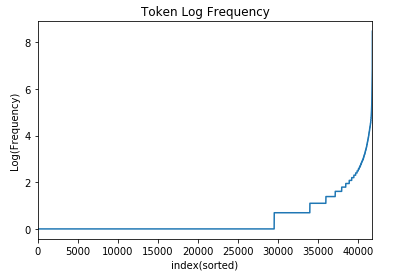

##### 1. Total number of tweets

In [ ]:
print("Total number of tweets: " + str(data.shape[0]))

##### 2. The total number of characters

In [ ]:
num = 0
for tweet in data.values:
    # Add to total character count
    num += len(tweet[0])
print("Total number of characters, including spaces: " + str(num))

##### 3. The total number of distinct words (vocabulary)

In [ ]:
# Define list that will hold all tokens
temp = []

# Iterate through each tweet
for text in data.values:
    # Each time the REGEX matches, add the matched string to the running list of all words
    for matches in my_extensible_tokenizer.findall(text[0]):       
         #just in case get empty matches
        if matches != '':
            # Add string to master list
            temp.append(matches)
            
# Define dictionary that will hold counts of all distinct tokens
corpus = {}

# Define variable that will hold counts of each word length
lengths = []

# Looking through entire list of (repeated) words, count instances of distinct words
for word in temp:
    # Add character count (non-whitespace) to counting list
    lengths.append(len(word))
    # If word has already been seen, add one to its count
    if word in corpus:
        corpus[word] += 1
    # If word has not already been seen, add word to list
    else:
        corpus[word] = 1
        
## temp contains urls, which are included in the count.  
## Are urls really words?
print("Number of distinct words: " + str(len(corpus)))

##### 4. The average number of characters and words in each tweet

In [ ]:
print("Average number of words per tweet is " + str(len(temp)/data.shape[0]))
data["characters"] = 0
# Write character count of each tweet to the character count column
data["characters"] = data["tweet"].str.len()
print("Average number of characters per tweet is" + str(data["characters"].mean()))

##### 5. The average number and standard deviation of characters per token

In [ ]:
print("Average number of characters per token: " + str(sum(lengths)/len(temp)))
print("Standard deviation of characters per token: " + str(stdev(lengths)))

##### 6. The total number of tokens corresponding to the top 10 most frequent words (types) in the vocabulary

In [ ]:
# Save dictionary of words and counts to dataframe to enable sorting by count
corpus_df = pd.DataFrame(list(corpus.items()), columns = ['word', 'count'])
# Sort by count, in descending fashion
corpus_df = corpus_df.sort_values(by=['count'],ascending=False)
# Sum counts from first 10 rows in sorted dataframe
Top10 = sum(corpus_df['count'][0:10])
print("Total number of times that 10 most popular tokens appear: " + str(Top10))

##### 7. The token/type ratio in the dataset

In [ ]:
print("Average number of times a specific word is seen (i.e. average number of tokens per type) is", len(temp)/len(corpus))

##### 8. The total number of distinct n-grams (of words) that appear in the dataset for n=2,3,4,5

In [ ]:
def GramCount(data,n):
    i = 0
    ngramlist = [] 
    while i < len(data):
        tokens = my_extensible_tokenizer.findall(data['tweet'][i])
        grams = list(ngrams(tokens, n)) 
        for gram in grams:
            ngramlist.append(gram)
        i += 1
    return(len(set(ngramlist)))

for i in range(2,6):    
      print("There are ", GramCount(data,i), " of distinct ", i,"-grams.",sep='')

##### 9. The total number of distinct n-grams of characters that appear for n=2,3,4,5,6,7

In [ ]:
# Construct dictionaries that will contain distinct character n-grams
n_2 = {}
n_3 = {}
n_4 = {}
n_5 = {}
n_6 = {}
n_7 = {}

num = 0
# Moving through all tweets in the data
for tweet in data.values:
    # Add to total character count
    num += len(tweet[0])
    
    # Moving through each letter of the tweet...
    # Creating distinct character n-grams
    for i in range(1,len(tweet[0])):
        # Form two-character combos (i.e. n-2 grams)
        string2 = tweet[0][i-1:i+1]
        # Check whether n-2 gram is already in corpus
        if string2 in n_2:
            # If already in corpus, add to count
            n_2[string2] += 1
        # If n-2 gram has not already been seen, add to list
        else:
            n_2[string2] = 1
        # For situations where we are at least 3 characters away from the end-character   
        if len(tweet[0]) - i >= 2:
            # Form three-character combo
            string3 = tweet[0][i-1:i+2]
            # Check whether n-3 gram is already in corpus
            if string3 in n_3:
                # If already in corpus, add to count
                n_3[string3] += 1
            # If n-3 has not already been seen, add to list
            else:
                n_3[string3] = 1
                
        ## Continue equivalently for n-4, n-5, n-6, n-7: check whether we're far
        ## enough away from end of tweet to form forward-looking string of that size,
        ## save the string, and either save new dict entry or add to dict counter
        if len(tweet[0]) - i >= 3:
            string4 = tweet[0][i-1:i+3]

            if string4 in n_4:
                n_4[string4] += 1
            # If n-4 gram has not already been seen, add to list
            else:
                n_4[string4] = 1
                
        if len(tweet[0]) - i >= 4:
            string5 = tweet[0][i-1:i+4]

            if string5 in n_5:
                n_5[string5] += 1
            # If n-5 gram has not already been seen, add to list
            else:
                n_5[string5] = 1
            
        if len(tweet[0]) - i >= 5:
            string6 = tweet[0][i-1:i+5]

            if string6 in n_6:
                n_6[string6] += 1
            # If n-6 gram has not already been seen, add to list
            else:
                n_6[string6] = 1
                
        if len(tweet[0]) - i >= 6:
            string7 = tweet[0][i-1:i+6]

            if string7 in n_7:
                n_7[string7] += 1
            # If n-7 gram has not already been seen, add to list
            else:
                n_7[string7] = 1  

print('There are ' + str(len(n_2)) + ' of distinct char 2-grams')
print('There are ' + str(len(n_3)) + ' of distinct char 3-grams')
print('There are ' + str(len(n_4)) + ' of distinct char 4-grams')
print('There are ' + str(len(n_5)) + ' of distinct char 5-grams')
print('There are ' + str(len(n_6)) + ' of distinct char 6-grams')
print('There are ' + str(len(n_7)) + ' of distinct char 7-grams')

##### 10. Plot a token log frequency. Describe what this plot means and how to interpret it. Describe how it might help you understand coverage when training a model?

In [ ]:
# Obtain frequency values from dict
tok_freqs = list(corpus.values())
# Take log of all freq counts
log_freqs = [log(x) for x in tok_freqs]
# Sort form least to greatest for use in plot
log_freqs.sort()
# Save list as series to enable plotting
logz = pd.Series(log_freqs)
# Plot log(freq) of each token, sorted from smallest to largest
logz.plot(use_index=False,title='Token Log Frequency')
plt.xlabel("Index(sorted)")
plt.ylabel("Log(Frequency)")

### 2. Gold Data

Number of word types that appear in dev data but not training data is 5,062.<br>

The number of distinct words in the input dataset is 41,760.
The number of distinct words in the gold dataset is 61,727.

Plot of lexicon size for different sample sizes N:<br>
LexiconSize-TotalTokens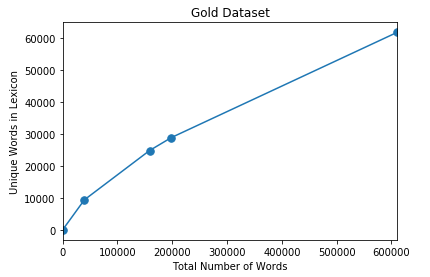


The number of positive tweets in the gold training dataset ("dev" + "training") is 3846.<br>
The number of neutral tweets in the gold training dataset is 2747.<br>
The number of negative tweets in the gold dataset is 1241.<br>

There is a lot of similarity between the top words across the three classes. However, we would like to note that "Donald", "Trump", "Erdogan", and "Jeb" appear in the top 60 of only the negative tweets. "Tomorrow" appears more frequently as tweets get more positive. "But" appears less frequently as tweets get more positive. "Friday" and "Jurassic" appear in the top 50 of only the positive tweets."Apple" appears in the top 50 of only the positive and neutral tweets. Also, "Amazon" and "Prime" both appear higher in the list of negative tweet frequency than "Amazon" does in the list of positive tweet frequency.<br>

The Dev dataset has frequent occurrences of Obama, SCOTUS, Sunday, Minecraft, Snoop, Rick, Sarah, planned, Ric, Palin, Dogg, Netflix, Nike, Serena, and Michelle, which suggests a larger political/pop culture theme for the dev dataset.<br>
The training dataset has frequent occurrences of Amazon, Friday, Apple, and night. The two sets are otherwise fairly similar, but the frequent words in the training set more closely match those seen in the overall positive, neutral, and negative subsets, suggesting that the training set is substantially larger.<br>

In [ ]:
#Reading in the data
data_dev = pd.read_csv("Gold/dev.txt", sep='\t', header=None, index_col=False,
                   names=['id', 'target', 'tweet'], encoding='utf-8')
data_dev.drop(['id'], axis=1, inplace=True)

data_train = pd.read_csv("Gold/train.txt", sep='\t', header=None, index_col=False,
                   names=['id', 'target', 'tweet'], encoding='utf-8')
data_train.drop(['id'], axis=1, inplace=True)

data_devtest = pd.read_csv("Gold/devtest.txt", sep='\t', header=None, index_col=False,
                           names=['id', 'target', 'tweet'], encoding='utf-8')
data_devtest.drop(['id'], axis=1, inplace=True)

data_test = pd.read_csv("Gold/test.txt", sep='\t', header=None, index_col=False,
                           names=['id', 'target', 'tweet'], encoding='utf-8')
data_test.drop(['id'], axis=1, inplace=True)

# Define list that will hold all token types for Gold dev data
temp_gold_dev = []

for text in data_dev['tweet'].values:
    # Each time the REGEX matches, add the matched string to the running list of all words
    for matches in my_extensible_tokenizer.findall(text):
         #just in case get empty matches
        if matches != '':
            # Add string to master list
            temp_gold_dev.append(matches)
            
# Define list that will hold all token types for Gold training data
temp_gold_train = []

for text in data_train['tweet'].values:
    # Each time the REGEX matches, add the matched string to the running list of all words
    for matches in my_extensible_tokenizer.findall(text):
         #just in case get empty matches
        if matches != '':
            # Add string to master list
            temp_gold_train.append(matches)
         
                        
# Define list that will hold all token types for Gold DEVTEST data
temp_gold_devtest = []

for text in data_devtest['tweet'].values:
    # Each time the REGEX matches, add the matched string to the running list of all words
    for matches in my_extensible_tokenizer.findall(text):
         #just in case get empty matches
        if matches != '':
            # Add string to master list
            temp_gold_devtest.append(matches)
     
        
# Define list that will hold all token types for Gold test data
temp_gold_test = []

for text in data_test['tweet'].values:
    # Each time the REGEX matches, add the matched string to the running list of all words
    for matches in my_extensible_tokenizer.findall(text):
         #just in case get empty matches
        if matches != '':
            # Add string to master list
            temp_gold_test.append(matches)


# Create null dictionaries that will store types and counts for each dataset
corpus_gold_dev = {}
corpus_gold_train = {}
corpus_gold_devtest = {}
corpus_gold_test = {}
# Create null dictionary that will store types and counts for all gold datasets combined
corpus_gold = {}

# Looking through entire list of (repeated) words, count instances of distinct words
for word in temp_gold_dev:
    # If word has already been seen, add one to its count
    if word in corpus_gold_dev:
        corpus_gold_dev[word] += 1
    # If word has not already been seen, add word to list
    else:
        corpus_gold_dev[word] = 1
    if word in corpus_gold:
        corpus_gold[word] += 1
    else:
        corpus_gold[word] = 1
# Number of unique words in dev set
unique1 = len(corpus_gold)

# Looking through entire list of (repeated) words, count instances of distinct words
for word in temp_gold_train:
    # If word has already been seen, add one to its count
    if word in corpus_gold_train:
        corpus_gold_train[word] += 1
    # If word has not already been seen, add word to list
    else:
        corpus_gold_train[word] = 1
        
    if word in corpus_gold:
        corpus_gold[word] += 1
    else:
        corpus_gold[word] = 1
# Number of unique words in training set
unique2 = len(corpus_gold)

# Looking through entire list of (repeated) words, count instances of distinct words
for word in temp_gold_devtest:
    # If word has already been seen, add one to its count
    if word in corpus_gold_devtest:
        corpus_gold_devtest[word] += 1
    # If word has not already been seen, add word to list
    else:
        corpus_gold_devtest[word] = 1

    if word in corpus_gold:
        corpus_gold[word] += 1
    else:
        corpus_gold[word] = 1       
# Number of unique words in devtest set
unique3 = len(corpus_gold)

# Looking through entire list of (repeated) words, count instances of distinct words
for word in temp_gold_test:
    # If word has already been seen, add one to its count
    if word in corpus_gold_test:
        corpus_gold_test[word] += 1
    # If word has not already been seen, add word to list
    else:
        corpus_gold_test[word] = 1

    if word in corpus_gold:
        corpus_gold[word] += 1
    else:
        corpus_gold[word] = 1     
# Number of unique words in test set
unique4 = len(corpus_gold)

##### 11. What is the number of types that appear in the dev data but not the training data (OOV)?

In [ ]:
# Define variable that will store values found in exclusively the dev data
justdev = corpus_gold_dev.keys() - corpus_gold_train.keys()
print('Number of types found in dev data but not in training data: ' + str(len(justdev)))

##### 12. Look at the vocabulary growth (types) combining your four gold data sets against your input data. Plot vocabulary growth at difference sample sizes N

In [ ]:
print("Distinct words in input dataset: " + str(len(corpus)) + "\nDistinct words in gold dataset: " + str(len(corpus_gold)))

# Save number of tokens in dev set
full1 = len(temp_gold_dev)
# Save number of tokens in training set        
full2 = len(temp_gold_train)   
# Save number of tokens in devset   
full3 = len(temp_gold_devtest) 
# Save number of tokens in test set
full4 = len(temp_gold_test)

# Each point represents the number of distinct words after having added one of the four subsets of the gold dataset
# (recorded during the creation of the full gold corpus in question 11) and the contribution to the total token
# count made by that subset.
lexicon = pd.DataFrame({'unique':[0,unique1,unique2,unique3,unique4],'total':[0,full1,full1+full2,full1+full2+full3,full1+full2+full3+full4]})
lexicon.plot(x ='total', y='unique', kind = 'line', title='Gold Dataset',marker='.', markersize=15,legend=None)
plt.xlabel("Total Number of Words")
plt.ylabel("Unique Words in Lexicon")

##### 13. What is the class distribution of the training data set - how many negative, neutral, positive tweets?

In [ ]:
#Unique values of the class column for the training data set
uniqgold = set(data_train['target']) 

numuniq = []
for value in uniqgold:
    count = 0
    for value2 in data_train['target']:
        if value2 == value:
            count += 1
    numuniq.append(count)

uniqlist = {'Class':list(uniqgold), 'Number of Tweets': numuniq}
uniqdf = pd.DataFrame(uniqlist)
uniqdf   

##### 14. Look at the difference between the top word types across these three classes

In [ ]:
positive = data_train[data_train['target'] == 'positive']
neutral = data_train[data_train['target'] == 'neutral']
negative = data_train[data_train['target'] == 'negative']

temp_pos = []
for text in positive['tweet'].values:
    # Each time the REGEX matches, add the matched string to the running list of all words
    for matches in my_extensible_tokenizer.findall(text):
         #just in case get empty matches
        if matches != '':
            # Add string to master list
            temp_pos.append(matches)

temp_neu = []
for text in neutral['tweet'].values:
    # Each time the REGEX matches, add the matched string to the running list of all words
    for matches in my_extensible_tokenizer.findall(text):
         #just in case get empty matches
        if matches != '':
            # Add string to master list
            temp_neu.append(matches)
 
temp_neg = []
for text in negative['tweet'].values:
    # Each time the REGEX matches, add the matched string to the running list of all words
    for matches in my_extensible_tokenizer.findall(text):
         #just in case get empty matches
        if matches != '':
            # Add string to master list
            temp_neg.append(matches)

corpus_pos = {}
# Looking through entire list of (repeated) words, count instances of distinct words
for word in temp_pos:
    # If word has already been seen, add one to its count
    if word in corpus_pos:
        corpus_pos[word] += 1
    # If word has not already been seen, add word to list
    else:
        corpus_pos[word] = 1
    
pos_df = pd.DataFrame(list(corpus_pos.items()), columns = ['word', 'count'])
# Sort by count, in descending fashion
pos_df = pos_df.sort_values(by=['count'],ascending=False)
   
corpus_neu = {}
# Looking through entire list of (repeated) words, count instances of distinct words
for word in temp_neu:
    # If word has already been seen, add one to its count
    if word in corpus_neu:
        corpus_neu[word] += 1
    # If word has not already been seen, add word to list
    else:
        corpus_neu[word] = 1

neu_df = pd.DataFrame(list(corpus_neu.items()), columns = ['word', 'count'])
# Sort by count, in descending fashion
neu_df = neu_df.sort_values(by=['count'],ascending=False)


corpus_neg = {}
# Looking through entire list of (repeated) words, count instances of distinct words
for word in temp_neg:
    # If word has already been seen, add one to its count
    if word in corpus_neg:
        corpus_neg[word] += 1
    # If word has not already been seen, add word to list
    else:
        corpus_neg[word] = 1

neg_df = pd.DataFrame(list(corpus_neg.items()), columns = ['word', 'count'])
# Sort by count, in descending fashion
neg_df = neg_df.sort_values(by=['count'],ascending=False)

Top51 = pd.DataFrame()
Top51['pos'] = pos_df['word'].values[0:50]
Top51['neu'] = neu_df['word'].values[0:50]
Top51['neg'] = neg_df['word'].values[0:50]
Top51

##### 15. What words are particularly characteristic of your training set and dev set? Are they the same?

In [ ]:
# Save training dictionary to dataframe so that it can be ordered by count
train_df = pd.DataFrame(list(corpus_gold_train.items()), columns = ['word', 'count'])
# Sort by count, in descending fashion
train_df = train_df.sort_values(by=['count'],ascending=False)

# Save dev dictionary to dataframe so that it can be ordered by count
dev_df = pd.DataFrame(list(corpus_gold_dev.items()), columns = ['word', 'count'])
# Sort by count, in descending fashion
dev_df = dev_df.sort_values(by=['count'],ascending=False)

Top61 = pd.DataFrame()
Top61['train'] = train_df['word'].values[0:60]
Top61['dev'] = dev_df['word'].values[0:60]
Top61

***

## Task 2: Message Polarity

We began by creating a fairly straightforward tokenizer that selected usernames, hashtags, abbreviations, URLs, numerical stuff, hyphenated and apostrophized words, and exclusively alpha strings. We then removed URLs, numbers, and usernames from what would be submitted to the sentiment evaluators, because they are both unlikely to convey sentiment or appear in that exact form in the test set. We also removed a list of extremely common words that are also unlikely to convey sentiment. Regarding this tokenization process, we found that the sequencing of the REGEX terms in the tokenizer was extremely consequential for the performance of the sentiment analysis. Regarding the removal process, the removal of "stop" words, URLs, and usernames was a pretty obvious set of steps, as it removed a great deal of noise (i.e. strings that did not convey sentiment) from the training data. The debate around including or excluding numbers was more robust. We ultimately opted to remove numbers because the value added by including bigrams/trigrams/4-grams that included numerals did not make up for the noisse created by context-free numeric unigrams.<br><br>

After tokenization and removal, we implemented a few more advanced techniques. We appended "not" to the end of all words in a tweet following the appearance of a negation in order to capture the distinction between "...good" and "...wasn't good". We also appended tags indicating the part of speech that each word represented. We also created n-grams up to size n=4 to capture sentiment-communicating phrases. Finally, we implemented a random oversampler to account for the substantial difference in the number of tweets in the training data belonging to each class (3846 positive, 2747 neutral, and only 1241 negative). Reviewing each of these steps, the appending of "not" and the use of n-grams actually decreased the quality of the model on the Gold data. However, we assess that this is due to overfitting, as neither the training nor test set is especially large and both of these techniques increase the fractility of the model. The parts-of-speech model conferred small improvements to the model's performance, but this process was extremely computationally costly. Therefore, we performed minimial tests including it with different combinations of other techniques because it was so time-consuming. The introduction of the oversampler created marked improvements in performance, addressing the more than 3-to-1 disparity between positive and negative tweet volume in the training data.<br><br>

In [ ]:
# Import the packages
import re 
import pandas as pd 
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment import SentimentAnalyzer
import nltk 
from nltk.tag import pos_tag
from nltk.corpus import stopwords
import random
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Read in the data
data_dev = pd.read_csv("Gold/dev.txt", sep='\t', header=None, index_col=False,
                   names=['id', 'target', 'tweet'], encoding='utf-8')
data_dev.drop(['id'], axis=1, inplace=True)

data_train = pd.read_csv("Gold/train.txt", sep='\t', header=None, index_col=False,
                   names=['id', 'target', 'tweet'], encoding='utf-8')
data_train.drop(['id'], axis=1, inplace=True)

data_devtest = pd.read_csv("Gold/devtest.txt", sep='\t', header=None, index_col=False,
                           names=['id', 'target', 'tweet'], encoding='utf-8')
data_devtest.drop(['id'], axis=1, inplace=True)

data_test = pd.read_csv("Gold/test.txt", sep='\t', header=None, index_col=False,
                           names=['id', 'target', 'tweet'], encoding='utf-8')
data_test.drop(['id'], axis=1, inplace=True)

'''
kaggle_data = a = pd.read_csv("Gold/kaggle_data.csv", encoding='iso-8859-1',
                              names=["target", "ids", "date", "flag", "user", "tweet"])
kaggle_data.drop(['ids','flag','date','user'],axis=1,inplace=True)
kaggle_data.loc[kaggle_data.loc[:, 'target'] == 0, 'target'] = 'negative'
kaggle_data.loc[kaggle_data.loc[:, 'target'] == 4, 'target'] = 'positive'
kaggle_data = kaggle_data.sample(frac=1).reset_index(drop=True).loc[0:50000,:]

data_dev = data_dev.append(kaggle_data, ignore_index=True)
'''

# Tokenize
regexes=(
# Keep usernames together (any token starting with @, followed by A-Z, a-z, 0-9)        
r"(?:@[\w_]+)",

# Keep hashtags together (any token starting with #, followed by A-Z, a-z, 0-9, _, or -)
r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)",

# abbreviations, e.g. U.S.A.
r'(?:[A-Z]\.)+',
r'[A-Za-z]\.(?:[A-Za-z0-9]\.)+',
r'[A-Z][bcdfghj-np-tvxz]+\.',

# URL, e.g. https://google.com Ryans's url pattern.
r'https?:\/\/w{0,3}\.?[a-zA-Z0-9-]+\.[a-zA-Z0-9]{1,6}\/?[a-zA-Z0-9\/=]*\s*',
r'w{3}\.[a-zA-Z0-9]+\.[a-zA-Z0-9\/=]+\s*',
r'w{0:3}\.?[a-zA-Z0-9]+\.[a-zA-Z0-9\/=]+\/+[a-zA-Z0-9\/=]*\s*',
r'[a-zA-Z0-9]+\.com\/?[a-zA-Z0-9\/=]*\s*',
r'[a-zA-Z0-9]+\.edu\/?[a-zA-Z0-9\/=]*\s*',
r'[a-zA-Z0-9]+\.gov\/?[a-zA-Z0-9\/=]*\s*',
r'[a-zA-Z0-9]+\.org\/?[a-zA-Z0-9\/=]*\s*',

# currency and percentages, e.g. $12.40, 82%
r'\$?\d+(?:\.\d+)?%?',

# Numbers i.e. 123,56.34
r'(?:[0-9]+[,]?)+(?:[.][0-9]+)?',

# Keep words with apostrophes, hyphens and underscores together
r"(?:[a-z][a-z’'\-_]+[a-z])",

# Keep all other sequences of A-Z, a-z, 0-9, _ together
r"(?:[\w_]+)",

# Match words at the end of a sentence.  e.g. tree. or tree!
r'(?:[a-z]+(?=[.!\?]))',

# Everything else that's not whitespace
# It seems like this captures punctuations and emojis and emoticons.  
#r"(?:\S)"
)
big_regex = "|".join(regexes)
my_extensible_tokenizer = re.compile(big_regex, re.VERBOSE | re.I | re.UNICODE)


trash_pattern = (
# URL, e.g. https://google.com
# This pattern will match any url.  
r'(https?:\/\/(?:www\.',
r'(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}',
r'www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}',
r'https?:\/\/(?:www\.',
r'(?!www))[a-zA-Z0-9]+\.[^\s]{2,}',
r'www\.[a-zA-Z0-9]+\.[^\s]{2,})',

# Numbers i.e. 123,56.34
r'(?:[0-9]+[,]?)+(?:[.][0-9]+)?',

# Keep usernames together (any token starting with @, followed by A-Z, a-z, 0-9)        
r"(?:@[\w_]+)"
)

big_trash_pattern = "|".join(trash_pattern)
trash_tokenizer = re.compile(big_trash_pattern, re.VERBOSE | re.I | re.UNICODE)

hashtag_pattern = (
r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)"        
)
hashtag_tokenizer = re.compile(hashtag_pattern, re.VERBOSE | re.I | re.UNICODE)

url_pattern = (
# URL, e.g. https://google.com
# This pattern will match any url.
r'https?:\/\/w{0,3}\.?[a-zA-Z0-9-]+\.[a-zA-Z0-9]{1,6}\/?[a-zA-Z0-9\/=]*\s*',
r'w{3}\.[a-zA-Z0-9]+\.[a-zA-Z0-9\/=]+\s*',
r'w{0:3}\.?[a-zA-Z0-9]+\.[a-zA-Z0-9\/=]+\/+[a-zA-Z0-9\/=]*\s*',
r'[a-zA-Z0-9]+\.com\/?[a-zA-Z0-9\/=]*\s*',
r'[a-zA-Z0-9]+\.edu\/?[a-zA-Z0-9\/=]*\s*',
r'[a-zA-Z0-9]+\.gov\/?[a-zA-Z0-9\/=]*\s*',
r'[a-zA-Z0-9]+\.org\/?[a-zA-Z0-9\/=]*\s*',
)
big_url_pattern = "|".join(url_pattern)
url_tokenizer = re.compile(big_url_pattern, re.VERBOSE | re.I | re.UNICODE)

# Create a list of stop words
stops = list(stopwords.words('english')) 
stop_words = []
for word in stops:
    if word[-3:] != "n't":
        if word[-1] != 'n':
            stop_words.append(word)
            
# Create a list of negation words         
negation_words = ['not', 
                  'no', 
                  'never',
                  'none',
                  'no one',
                  'nobody',
                  'nothing',
                  'neither',
                  'never',
                  'hardly',
                  'scarcely',
                  'barely',
                  "doesn't",
                  "isn't",
                  "wasn't",
                  "shouldn't",
                  "wouldn't",
                  "couldn't",
                  "won't",
                  "can't",
                  "don't"
                  ]

def randomOversampler(DataFrame):
    # Assumption is that positive class always majority.  
    # This is true for current datasets.  
    neutral_tweets = DataFrame.loc[DataFrame['target'] == 'neutral', :]
    negative_tweets = DataFrame.loc[DataFrame['target'] == 'negative', :]
    neu_rows = neutral_tweets.shape[0]
    neg_rows = negative_tweets.shape[0]
    pos_class_count = DataFrame.groupby(by='target').count().loc['positive',:][0]
    neg_class_count = DataFrame.groupby(by='target').count().loc['negative',:][0]
    neu_class_coutn = DataFrame.groupby(by='target').count().loc['neutral',:][0]
    neu_nums = random.choices(range(neu_rows), k=pos_class_count-neu_class_coutn)
    neg_nums = random.choices(range(neg_rows), k=pos_class_count-neg_class_count)
    DataFrame = DataFrame.append(neutral_tweets.iloc[neu_nums,:], ignore_index=True)
    DataFrame = DataFrame.append(negative_tweets.iloc[neg_nums,:], ignore_index=True)
    return DataFrame

def tweettag(tweet):
    tags = [
            'JJ',
            'NN',
            'NNS',
            'IN',
            'JJR',
            'JJS',
            'POS',
            'RB',
            'RBR',
            'RBS',
            'VB',
            'VBD',
            'BVG',
            'VBN',
            'VBP',
            'VBZ',
            'WRB'
            ]
    twt = []    
    for tag in tags:
        for word in pos_tag(my_extensible_tokenizer.findall(tweet), tagset='universial'):
            if word[1] in tag:
                twt.append((tag,True))
    return(twt)

def url_processsing(text, list):
    url_matches = url_tokenizer.findall(text)
    if url_matches:
        list.append(('url_flag', True))
#        list.append(('url_count', len(url_matches)))
#        list.append(('url_count_2', len(url_matches)**3))
#    elif not url_matches:
#        list.append(('url_count', 0))
#        list.append(('url_count_2', 0))
    return list

def hashtag_processing(text, list):
    hashtag_matches = hashtag_tokenizer.findall(text)
    if hashtag_matches:
        list.append(('hashtag_flag', True))
#        list.append(('hashtag_flag', len(hashtag_matches)))
#        list.append(('hashtag_flag_2', len(hashtag_matches)**2))
#    elif not hashtag_matches:
#        list.append(('hashtag_flag', 0))
#        list.append(('hashtag_flag_2', 0))
    return list

def textPolarity(str, list, sia):
    pol = sia.polarity_scores(str)
    if pol['neg'] > .8:
        list.append((str + '(neg)', True))
    if pol['pos'] > .8:
        list.append((str + '(pos)', True))
    if pol['neu'] > .8:
        list.append((str + '(neu)', True))
    return list

def preprocessing(data):
    tokens = [] # stores all features for dataset.  
    sia = nltk.sentiment.vader.SentimentIntensityAnalyzer()
    for text in data.values: # for each tweet.  
        temp = []  # stores the modified matches for a single tweet
        temp3 = [] # stores just the words (with negation, if applicable) for inclusion in n-grams
        NOT = 0 # setting variable to 0 that will trigger the variable "negate" to append "_not" to all words following "n't" or "not" in a tweet
        negate = 0 # set variable to 0 that, when equal to 1, will append "_not" to all words following an instance of "n't" or "not"
        for matches in my_extensible_tokenizer.findall(text[1]):
            matches = matches.lower()
            # determine if matches is a url.
            # Set NOT to 1, where it will remain for remainder of tweet until new row resets NOT to 0
            if (matches[-3:] == "n't" or matches in negation_words):
                NOT = 1
            trash_matches = trash_tokenizer.findall(matches)
            temp = url_processsing(matches, temp)
            temp = hashtag_processing(matches, temp)
            temp = textPolarity(matches, temp, sia) 
            # if the match is unwanted, then won't add to temp.  
            if not trash_matches and matches !='':
                #whatisthis = nltk.tag.pos_tag([matches])[0][1]
                if matches not in stop_words:
                    # If the NOT trigger was previously activated in this tweet, add "_not" to this (and all subsequent) words
                    if negate == 1:
                        matches = matches + '_not'
                    temp.append(('contains(' + matches + ')', True))
                    # Add to list of tokens in this tweet
                    temp.append(('contains(' + matches.lower() + ')', True))
                    # Add backward-looking 2-gram, if possible
                    if len(temp3) > 0:
                        temp.append(('contains(' + temp3[-1] + ' ' + matches.lower() + ')', True))
                    # Add backward-looking 3-gram, if possible
                    if len(temp3) > 1:
                        temp.append(('contains(' + temp3[-2] + ' ' + temp3[-1] + ' ' + matches.lower() + ')', True))
                    # Add backward-looking 4-gram, if possible
                    if len(temp3) > 2:
                        temp.append(('contains(' + temp3[-3] + ' ' + temp3[-2] + ' ' + temp3[-1] + ' ' + matches.lower() + ')', True))
                    # Add to running list of words being saved for n-grams
                    temp3.append(matches.lower())
            # Activate _not trigger if this word ended with "n't" or was "not"
            if NOT == 1:
                negate = 1
        temp = temp + tweettag(text[1])
        tokens.append((dict(temp), text[0]))
    return tokens

# Define function that performs VADER on dataset and returns accuracy of VADER's sentiment analysis
def vader(data):
    # Stores list of results of VADER process for each tweet
    vader = []
    # for each tweet  
    for text in data.values:
        # stores just the words (no negation) for inclusion in VADER
        temp2 = []
        # For each word in the tweet
        for matches in my_extensible_tokenizer.findall(text[1]):
            # If word doesn't register as a URL or username
            trash_matches = trash_tokenizer.findall(matches)
            if not trash_matches:
                if matches != '':
                    # And if word is not in list of stopwords
                    if nltk.tag.pos_tag([matches])[0][1] not in stop_words:
                        # Add to running list of tokens being saved for Vader
                        temp2.append(matches.lower())
        # Join all surviving tokens from tweet into clean single string
        sentence = " ".join(temp2)
        # Run VADER on string  
        vs = analyzer.polarity_scores(sentence)
        # Assign score to tweet based on VADER's compound statistic
        if vs['compound'] < -.05:
            score = 'negative'
        elif vs['compound'] > .05:
            score = 'positive'
        else:
            score = 'neutral'
        # Add this tweet's score to list of all scores
        vader.append(score)
    # Create dataframe that stores VADER sentiment result and true sentiment label in same row
    vadertest = pd.DataFrame({'true':data['target'],'test':vader})
    # Compute series that contains counts of each possible pairing of VADER result and true tweet sentiment
    b = vadertest.groupby(["true", "test"]).size()

    # Calculate all statistics evaluating VADER's performance
    accuracy = (b['positive','positive']+b['neutral','neutral']+b['negative','negative'])/len(vadertest)
    precision_pos = b['positive','positive']/(sum(vadertest['test']=='positive'))
    recall_pos = b['positive','positive']/sum(vadertest['true']=='positive')
    f_measure_pos = 2*(recall_pos * precision_pos) / (recall_pos + precision_pos)
    precision_neu = b['neutral','neutral']/(sum(vadertest['test']=='neutral'))
    recall_neu = b['neutral','neutral']/(sum(vadertest['true']=='neutral'))
    f_measure_neu = 2*(recall_neu * precision_neu) / (recall_neu + precision_neu)
    precision_neg = b['negative','negative']/(sum(vadertest['test']=='negative'))
    recall_neg = b['negative','negative']/(sum(vadertest['true']=='negative'))
    f_measure_neg = 2*(recall_neg * precision_neg) / (recall_neg + precision_neg)
    recall_avg = (recall_pos + recall_neu + recall_neg)/3
    # Print VADER's performance
    results = pd.Series({'Accuracy':accuracy,'Precision(Positive)':precision_pos,'Recall(Positive)':recall_pos,
                     'F-Measure(Positive)':f_measure_pos,'Precision(Neutral)':precision_neu,'Recall(Neutral)':recall_neu,
                     'F-Measure(Neutral)':f_measure_neu,'Precision(Negative)':precision_neg,'Precision(Neutral)':precision_neu,
                     'F-Measure(Negative)':f_measure_neg,'Average Recall':recall_avg})
    return(results)
    
data_dev = randomOversampler(data_dev)
data_train = randomOversampler(data_train)
data_devtest = randomOversampler(data_devtest)

train_tokens = preprocessing(data_train)
dev_tokens = preprocessing(data_dev)
devtest_tokens = preprocessing(data_devtest)
test_tokens = preprocessing(data_test)

training_features = train_tokens + dev_tokens + devtest_tokens
test_final = test_tokens # + devtest_tokens

sentiment_analyzer = SentimentAnalyzer()
trainer = NaiveBayesClassifier.train
classifier = sentiment_analyzer.train(trainer=trainer, training_set=training_features)

# Naive Bayes

# Evaluating model on training data
#sentiment_analyzer.evaluate(training_features, classifier)
# Evaluating model on test data
res1 = sentiment_analyzer.evaluate(test_final, classifier)
res1

# Vader 

# Evaluating model on training data
#vader(data_train)
# Evaluating model on test data
res2 = vader(data_test)
res2

***

## Task 3: Performance evaluation

[TBA]

In [ ]:
res11 = pd.DataFrame([res1])
res22 = pd.DataFrame([res2.to_dict()])
res = res11.append(res22)
res